In [2]:
%pylab inline
import sqlite3,copy,gc,os,random
import pandas as pd
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
import multiprocessing as mp
import time
import scipy,collections

matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/sn0wfree/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error, .output_result').toggle();">Toggle Code</button>

In [273]:
#import data
otherfactor =pd.read_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/h5/otherfactor.h5')[[u'date',  u'MktRF', u'SMB', u'HML', u'RF',
       u'GS_SMB', u'BG_SMB', u'GS_HML', u'BG_HML', 
       u'TBill1MoDaily']]


ofd = otherfactor[['date','TBill1MoDaily']]

#share =pd.read_csv('/Users/sn0wfree/Documents/python_projects/data_collection/API/Share/wrds/share2.csv')
#share_dict=dict([ (ticekr,pd.merge(df,ofd))   for ticekr,df in share.groupby('TICKER')])
Google=pd.read_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/h5/GS.h5')


Bloomberg=pd.read_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/h5/BG.h5')
Bloomberg_dict=dict([ (ticekr,df)   for ticekr,df in Bloomberg.groupby('TICKER')])


#otherfactor[['date','TBill1MoDaily']]

In [23]:
share =pd.read_csv('/Users/sn0wfree/Documents/python_projects/data_collection/API/Share/wrds/shares2.csv')[['date','TICKER','PRC','SHROUT','RET']]
##refine
share=share.dropna()
share.PRC=share.PRC.abs()
#share.TICKER=share.TICKER.astype('category')
share.SHROUT=share.SHROUT.astype(np.int64)
share['date'] = pd.to_datetime(share['date'],format ='%Y%m%d') 
#share =share.set_index('date')
share['MarketValue']=share['PRC']*share['SHROUT']
share.info()

share.to_hdf('share.h5','share',mode='a')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7928537 entries, 0 to 7987305
Data columns (total 6 columns):
date           datetime64[ns]
TICKER         object
PRC            float64
SHROUT         int64
RET            object
MarketValue    float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 423.4+ MB


/Users/sn0wfree/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['TICKER', 'RET']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [24]:
share=pd.read_hdf('share.h5','share')
share.head()
#share_with_gsGroup.to_hdf('share.h5','share_with_gsGroup',mode='a')
#pd.merge(gsindex[['date','AEPI']].set_index('date'),share[share['TICKER']=='AEPI'])

,date,TICKER,PRC,SHROUT,RET,MarketValue
0,2004-01-02,AEPI,9.65,8177,-0.009139,78908.05
1,2004-01-05,AEPI,9.97,8177,0.033161,81524.69
2,2004-01-06,AEPI,9.95,8177,-0.002006,81361.15
3,2004-01-07,AEPI,9.75,8177,-0.020100,79725.75
4,2004-01-08,AEPI,10.35,8177,0.061538,84631.95


In [31]:
allticker =set(share.TICKER)&set(gsindex.columns)
def combine(share_df,index_df,ticker,mode='GS'):
    if mode =='GS':
        newindex= index_df[['date',ticker]]
    
        newindex.columns =['date','GoogleSearchGroup']
    elif mode =='BG':
        newindex= index_df[['date','NEWS_HEAT_READ_DAVG']]
    
        newindex.columns =['date','BloombergGroup']
        
    return pd.merge(share_df[share_df.TICKER ==ticker],newindex,on='date')
    

share_with_gsGroup=pd.concat([combine(share_df,gsindex,t) for t,share_df in share.groupby('TICKER') if t in allticker],axis=0)
share_with_gsGroup.to_hdf('share.h5','share_with_gsGroup',mode='a')

In [179]:
#share=pd.read_hdf('share.h5','share')
Bloomberg=pd.read_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/h5/BG.h5')[['date','TICKER','NEWS_HEAT_READ_DAVG']]

Bloomberg['date']=pd.to_datetime(Bloomberg['date'],format='%Y%m%d')
Bloomberg_dict=dict([ (ticekr,df)   for ticekr,df in Bloomberg.groupby('TICKER')])
#share_with_all=pd.merge(share_with_gsGroup,Bloomberg,on=['date','TICKER'])
Google['date'] =pd.to_datetime(Google['date'],format='%Y%m%d')
Google=Google.set_index('date')
#share_with_all.to_hdf('share.h5','share_with_all',mode='a')

In [ ]:
def detectedHDFTable(HDFfile_path):
    #'share.h5'
    with pd.HDFStore(HDFfile_path) as share:
        return share.keys()
    share.close()
#share_with_all
detectedHDFTable('share.h5')

In [370]:
def GroupUPversion2(share_with_gsGroup,groupvalue='GoogleSearchGroup'):
    #groupvalue
    GS=[]
    for group,df in share_with_gsGroup.groupby(groupvalue):
        df=df.dropna()
        GroupedSeries =pd.Series({ date:sum(date_df.MarketValue)/float(sum(date_df.SHROUT))  for date,date_df in df.groupby('date')})
        #GroupedSeriesSHROUT =pd.Series({ date:sum(date_df.SHROUT)  for date,date_df in df.groupby('date')})


        GroupedSeries=GroupedSeries.to_frame('Group%d'%int(group))
        #GroupedSeriesSHROUT=GroupedSeriesSHROUT.to_frame('Group%d_SHROUT'%int(group))
        GS.append(GroupedSeries)
        #GS.append(GroupedSeriesSHROUT)
    
    return pd.concat(GS,axis=1)
    
GS=GroupUPversion2(share_with_gsGroup)
BG=GroupUPversion2(share_with_BGgroup,groupvalue='Group')



In [99]:
ye =lambda x : x.year
GS['year']=ye(GS.index)
BG['year']=ye(BG.index)

In [100]:
GS.to_csv('GSpricelevel.csv')
BG.to_csv('BGpricelevel.csv')

In [380]:
share_with_BGgroup

,TICKER,PRC,SHROUT,RET,MarketValue,NEWS_HEAT_READ_DAVG,Group
date,,,,,,,
2010-02-18,A,30.980,348892,0.011427,1.080867e+07,0.0,0
2010-02-19,A,31.200,348892,0.007101,1.088543e+07,0.0,0
2010-02-22,A,31.150,348892,-0.001603,1.086799e+07,0.0,0
2010-02-23,A,30.850,348892,-0.009631,1.076332e+07,0.0,0
2010-02-24,A,31.230,348892,0.012318,1.089590e+07,0.0,0
2010-02-25,A,31.090,348892,-0.004483,1.084705e+07,0.0,0
2010-02-26,A,31.460,348892,0.011901,1.097614e+07,0.0,0
2010-03-01,A,32.090,348892,0.020025,1.119594e+07,0.0,0
2010-03-02,A,32.360,348892,0.008414,1.129015e+07,0.0,0


In [27]:
#gsindex=pd.read_csv('/Users/sn0wfree/Documents/python_projects/data_collection/API/otherfactor/gsgroupindex.csv')
#bgindex.to_csv('/Users/sn0wfree/Documents/python_projects/data_collection/API/otherfactor/bggroupindex.csv')
#bgindex.to_hdf('bggroupindex.h5','bggroupindex')
#gsindex['date'] = pd.to_datetime(gsindex['date'],format ='%Y%m%d') 
#gsindex=gsindex.set_index('date')
#gsindex.to_hdf('gsgroupindex.h5','gsgroupindex')
gsindex=pd.read_hdf('gsgroupindex.h5','gsgroupindex')

In [182]:
#temp=Bloomberg_dict.values()[1]
temp_dict={}
for ticker,bg_df in Bloomberg_dict.items():
    bg_df['date'] = pd.to_datetime(bg_df['date'],format ='%Y-%m-%d') 
    bg_df=bg_df.set_index('date')
    bg_df.replace(183,4)
    temp_dict.update({ticker:{year:df['NEWS_HEAT_READ_DAVG'].mean() for year,df in bg_df.groupby(lambda x : x.year)}})
w =pd.DataFrame(temp_dict).T[[2010, 2011, 2012, 2013, 2014,2015, 2016]]
d=[]
for year in w.columns:
    ddd=[]
    for df in GroupChunk(w[[year]],5,year).values():
        df =df[['Group']]
        df.columns=[year]
        ddd.append(df)
    temp =pd.concat(ddd)
    d.append(temp)
bgindex=pd.concat(d,axis=1)

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [271]:
#bgindex.ix['A',2010]
print detectedHDFTable('share.h5')
share=pd.read_hdf('share.h5','share')
#share_with_bloomberg =share_with_all[[u'date', u'TICKER', u'PRC', u'SHROUT', u'RET', u'MarketValue', u'NEWS_HEAT_READ_DAVG']].dropna()
#share_with_bloomberg =share_with_bloomberg.set_index('date')
share_with_BGgroup=pd.read_hdf('share.h5','share_with_BGgroup')
share_with_gsGroup=pd.read_hdf('share.h5','share_with_gsGroup')

['/share', '/share_with_BGgroup', '/share_with_gsGroup']


In [1]:
share_with_BGgroup

NameError: name 'share_with_BGgroup' is not defined

In [386]:
bgindex=pd.read_hdf('bggroupindex.h5','bggroupindex',mode='a')

In [ ]:

def mu(tickeranddf):
    ticker,df =tickeranddf
    t=[]
    
    for year,year_df in df.groupby(lambda x : x.year):
        if year <2010:
            pass
        else:
            year_df['Group']=[bgindex.ix[ticker,year]]*year_df.shape[0] 
            t.append(year_df)
        
    return pd.concat(t)

pool=mp.Pool()

tt=pool.map(mu,share_with_BGgroup.groupby('TICKER'))
#for ticker,df in share_with_bloomberg.groupby('TICKER'):
pool.close()
pool.join()
    
rt=pd.concat(tt)      
        
        #print v
        



/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove th

In [ ]:
rt

In [381]:
#rt.to_hdf('share.h5','share_with_BGgroup',mode='w')
        
#rt.Group.describe()
#len(tt)

adjust_price={}
for year,df in BG.groupby(lambda x :x.year):
    
    if year == BG.index[0].year:
        base=0
        div=[1]*df.shape[1]
        last_period_price=df.iloc[-1]
        df=df/div
        
    else:
        base =year-1
        div = df.iloc[0]/adjust_price[base]['last_period_price']
        last_period_price =df.iloc[-1]/div
        df=df/div
    adjust_price.update({year:{'df':df,'base':base,'div':div,'last_period_price':last_period_price}})

BG_adjusted =pd.concat([ v['df'] for v in adjust_price.values()]).sort_index()  

In [383]:
adjust_price

{2010: {'base': 0, 'df':                Group0     Group1     Group2     Group3
  2010-02-17  20.107495  30.697404  33.877516  30.273300
  2010-02-18  20.229138  29.509075  34.297198  77.703473
  2010-02-23  20.755703  28.290967  33.395185  19.939899
  2010-02-24  20.806460  28.489280  33.505136  42.620000
  2010-02-25  20.713442  28.060679  33.300817  21.491904
  2010-03-01  20.930487  28.213089  33.754547  84.620000
  2010-03-02  20.732723  27.876486  33.909180  18.290000
  2010-03-08  21.267752  28.431465  34.022204  23.102057
  2010-03-10  24.126769  28.630116  34.265656  18.288929
  2010-03-11  23.735713  28.890239  34.366690  45.317858
  2010-03-12  23.709594  28.731508  33.727658  12.100000
  2010-03-22  23.815938  28.522525  34.809374  18.600000
  2010-03-23  23.725961  28.642630  35.383153  32.385114
  2010-03-25  24.047422  28.215390  35.059735  30.207505
  2010-03-26  24.495446  28.299337  34.779153  44.966371
  2010-03-30  24.514730  28.511915  34.919050  45.250000
  2010-0

In [147]:
#otherfactor['date']=pd.to_datetime(otherfactor['date'],format ='%Y%m%d') 
#otherfactor =otherfactor.set_index('date')

BG_adjusted_withFactors=BG_adjusted.join(otherfactor[['MktRF','SMB','HML','TBill1Mo']])
BG_adjusted_withFactors.to_hdf('PriceAdjustedGroup.h5','BGwithfactor')

In [378]:
BG.head()

,Group0,Group1,Group2,Group3
2010-02-17,20.107495,30.697404,33.877516,30.273300
2010-02-18,20.229138,29.509075,34.297198,77.703473
2010-02-23,20.755703,28.290967,33.395185,19.939899
2010-02-24,20.806460,28.489280,33.505136,42.620000
2010-02-25,20.713442,28.060679,33.300817,21.491904


In [167]:
GS_period ={0:('2004-01-01', '2004-08-31'),
 1:('2004-09-01', '2005-04-30'),
 2:('2005-05-01', '2005-12-31'),
 3:('2006-01-01', '2006-08-31'),
 4:('2006-09-01', '2007-04-30'),
 5:('2007-05-01', '2007-12-31'),
 6:('2008-01-01', '2008-08-31'),
 7:('2008-09-01', '2009-04-30'),
 8:('2009-05-01', '2009-12-31'),
 9:('2010-01-01', '2010-08-31'),
 10:('2010-09-01', '2011-04-30'),
 11:('2011-05-01', '2011-12-31'),
 12:('2012-01-01', '2012-08-31'),
 13:('2012-09-01', '2013-04-30'),
 14:('2013-05-01', '2013-12-31'),
 15:('2014-01-01', '2014-08-31'),
 16:('2014-09-01', '2015-04-30'),
 17:('2015-05-01', '2015-12-31'),
 18:('2016-01-01', '2016-08-31'),
 19:('2016-09-01', '2016-12-31')}
r=[]
for period_target,period_duration in GS_period.items():
    locals()['period%d'%period_target] = GS[(GS.date<=period_duration[1]) &  (GS.date>=period_duration[0])]
    locals()['period%d'%period_target]['period']=period_target
    r.append(locals()['period%d'%period_target])
rr =pd.concat(r).set_index('date')
adjust_price={}
rr=rr.sort_index()  
for period,df in rr.groupby('period'):
    
    if period == 0:
        base=0
        div=[1]*df.shape[1]
        last_period_price=df.iloc[-1]
        df=df/div
        
    else:
        base =period-1
        print base
        div = df.iloc[0]/adjust_price[base]['last_period_price']
        last_period_price =df.iloc[-1]/div
        df=df/div
    adjust_price.update({period:{'df':df,'base':base,'div':div,'last_period_price':last_period_price}})

GS_adjusted =pd.concat([ v['df'] for v in adjust_price.values()]).sort_index()
GS_adjusted_withFactors=GS_adjusted.join(otherfactor[['MktRF','SMB','HML','TBill1Mo']])
GS_adjusted_withFactors.to_hdf('PriceAdjustedGroup.h5','GSwithfactor')

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [302]:
GS_group=[  u'Group0',   u'Group1',   u'Group2',   u'Group3',   u'Group4',u'Group5',   u'Group6',   u'Group7',   u'Group8',   u'Group9']
BG_group=[  u'Group0',   u'Group1',   u'Group2',   u'Group3',   u'Group4']
GS_group_multicolumns=pd.MultiIndex.from_tuples([  ('Group0','PRC'), (u'Group1','PRC'), (u'Group2','PRC'), (u'Group3','PRC'), (u'Group4','PRC'),(u'Group5','PRC'), (u'Group6','PRC'), (u'Group7','PRC'), (u'Group8','PRC'), (u'Group9','PRC')],names=['Group', 'Variable'])
BG_group_multicolumns=pd.MultiIndex.from_tuples([('Group0','PRC'), (u'Group1','PRC'), (u'Group2','PRC'), (u'Group3','PRC'), (u'Group4','PRC')],names=['Group', 'Variable'])

In [297]:
print detectedHDFTable('PriceAdjustedGroup.h5')
gs_selelcted=[  u'Group0',   u'Group1',   u'Group2',   u'Group3',   u'Group4',
         u'Group5',   u'Group6',   u'Group7',   u'Group8',   u'Group9',    u'MktRF',      u'SMB',      u'HML', u'TBill1Mo']
GS_adjuested_group = pd.read_hdf('PriceAdjustedGroup.h5','GSwithfactor')[gs_selelcted]
BG_adjuested_group = pd.read_hdf('PriceAdjustedGroup.h5','BGwithfactor')
BG_adjuested_group.columns =pd.MultiIndex.from_tuples(zip(BG_adjuested_group.columns,['PRC']*len(BG_adjuested_group.columns)),names=['Group', 'Variable'])
GS_adjuested_group.columns =pd.MultiIndex.from_tuples(zip(GS_adjuested_group.columns,['PRC']*len(GS_adjuested_group.columns)),names=['Group', 'Variable'])




['/BGwithfactor', '/GSwithfactor']


In [7]:
#BG_adjuested_group[BG_group_multicolumns]

pd.read_hdf('PriceAdjustedGroup.h5','GSwithfactor')

,Group0,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,Group9,period,MktRF,SMB,HML,TBill1Mo
date,,,,,,,,,,,,,,,
2004-01-02,22.251584,37.026713,24.588964,26.315579,28.481373,36.310220,35.335275,33.425153,39.440117,36.630785,0.0,-0.0017,0.0082,0.0044,0.000024
2004-01-05,22.654781,36.828659,25.022889,26.842117,28.734088,36.553569,35.737365,33.961327,39.860258,36.975658,0.0,0.0120,0.0043,0.0003,0.000024
2004-01-06,22.698000,36.710960,25.070417,26.707350,28.794057,36.598533,35.757513,34.069283,39.916827,36.987118,0.0,0.0020,0.0011,0.0020,0.000024
2004-01-07,22.783754,36.685961,25.052540,26.862161,28.856935,36.700433,35.831781,34.175693,39.920591,37.067112,0.0,0.0034,0.0051,-0.0007,0.000024
2004-01-08,22.740948,36.354657,25.341959,27.138702,29.031024,36.824857,35.890116,34.486554,39.875632,37.210841,0.0,0.0045,0.0035,0.0066,0.000024
2004-01-09,22.599549,36.095617,25.115247,26.906495,28.916342,36.654868,35.686328,34.197925,39.568298,36.894173,0.0,-0.0072,0.0004,0.0022,0.000024
2004-01-12,22.808634,36.666632,25.537036,27.090309,29.173923,36.822732,35.753819,34.402084,39.726723,37.002099,0.0,0.0057,0.0091,0.0006,0.000024
2004-01-13,22.707470,36.539877,25.276377,26.820184,29.020518,36.796877,35.386230,34.163805,39.563267,36.840575,0.0,-0.0051,0.0019,0.0009,0.000024
2004-01-14,22.837331,36.834289,25.506895,27.014996,29.237324,37.005887,35.631361,34.417625,39.854912,37.129136,0.0,0.0080,-0.0007,0.0039,0.000023


In [167]:
BG_group_multicolumns[1][0]

u'Group1'

In [362]:
def CalculateMAMAPbymulticolumns(DataFrame,col,ma_list ='Default'):
    #DataFrame=DataFrame.fillna(0)
    # 分别计算5日、20日、30/60/100/200日的移动平均线
    if ma_list == 'Default':
        ma_list = [5,10, 20,30,50, 60,100,200]

    elif isinstance(ma_list,list) or isinstance(ma_list,tuple) or isinstance(ma_list,set):
        ma_list =ma_list
    else:
        print 'Unknown list, use Default list:5,10,20,30,60,100,200d MA'
        ma_list = [5,10, 20,30, 50,60,100,200]
    
    for group in col:
        DataFrame[group[0],'RET'] =DataFrame[group].diff()
        DataFrame[group[0],'RETrate'] =DataFrame[group].diff()/DataFrame[group]
        
        for ma in ma_list:
            DataFrame[group[0],'MA_' + str(ma)]= DataFrame[group].rolling(window=ma,center=False).mean()
            #magroup =(group[0],'MA_' + str(ma))
            DataFrame = recMAPretestbymulticolumns(DataFrame,str(ma),group)
    return DataFrame
def recMAPretestbymulticolumns(GS,ma,group):
    #print group[0]
    GS[group ]=abs(GS[group])
    GS[group[0],'MA_'+ma ]=abs(GS[group[0],'MA_'+ma])
    temp = GS[group] -GS[group[0],'MA_'+ma]
    GS[group[0],'buysignalforMA%s'%ma]=[1 if r>0 else 0 for r in temp]
    #GS[group[0],'MA%stiming'%ma] =GS[group[0],'RETrate'].shift(1)*GS[group[0],'buysignalforMA%s'%ma]+GS['TBill1Mo','PRC'].shift(1)*(1-GS[group[0],'buysignalforMA%s'%ma])
    GS[group[0],'MA%stiming'%ma] =GS[group[0],'RETrate']*GS[group[0],'buysignalforMA%s'%ma]+GS['TBill1Mo','PRC']*(1-GS[group[0],'buysignalforMA%s'%ma])
    GS[group[0],'MAP%s'%ma] =GS[group[0],'MA%stiming'%ma]-GS[group[0],'RETrate']
    GS[group[0],'MAP%s_dummy'%ma] =[1 if n>0 else 0 for n in GS[group[0],'MAP%s'%ma]]
    return GS

In [363]:
BGtest =CalculateMAMAPbymulticolumns(BG_adjuested_group,BG_group_multicolumns)

GStest =CalculateMAMAPbymulticolumns(GS_adjuested_group,GS_group_multicolumns)

                  count      mean       std       min       25%       50%  \
Group  Variable                                                             
Group0 RET       3272.0  0.001788  0.262898 -1.367194 -0.147923  0.008298   
Group1 RET       3272.0  0.003309  0.432306 -2.379770 -0.229878  0.018422   
Group2 RET       3272.0  0.003931  0.304459 -1.618598 -0.161619  0.018713   
Group3 RET       3272.0  0.002678  0.320978 -2.211380 -0.164011  0.016343   
Group4 RET       3272.0  0.004348  0.363983 -2.244298 -0.172193  0.016910   
Group5 RET       3272.0  0.005670  0.469237 -5.630699 -0.219099  0.026931   
Group6 RET       3272.0  0.004935  0.421539 -3.119078 -0.185210  0.024628   
Group7 RET       3272.0  0.006214  0.409744 -2.971443 -0.187420  0.023499   
Group8 RET       3272.0  0.005495  0.473533 -4.041260 -0.202962  0.022286   
Group9 RET       3272.0  0.002982  0.395984 -2.388394 -0.164449  0.017438   

                      75%       max  
Group  Variable                      

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x142146bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14c742a50>]], dtype=object)

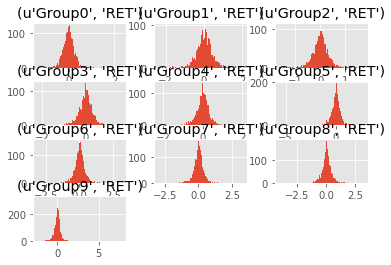

In [361]:
pd.set_option('display.multi_sparse', True)
GSRET =GStest.xs(('RET'),level='Variable', axis=1,drop_level=False).describe().T
GSRETrate =GStest.xs(('RETrate'),level='Variable', axis=1,drop_level=False).describe().T
GSMA10timing=GStest.xs(('MA10timing'),level='Variable', axis=1,drop_level=False).describe().T
GSMAP10= GStest.xs(('MAP10'),level='Variable', axis=1,drop_level=False).describe().T
print GSRET
print GSMAP10

GStest.xs(('RET'),level='Variable', axis=1,drop_level=False).hist(bins=200)

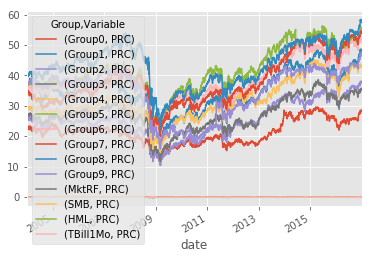

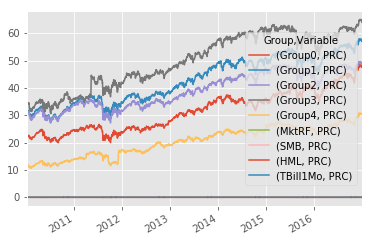

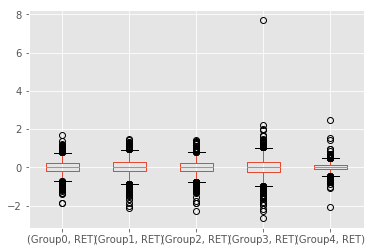

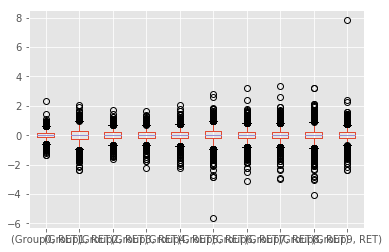

In [311]:
GStest.xs(('PRC'),level='Variable', axis=1,drop_level=False).plot()
BGtest.xs(('PRC'),level='Variable', axis=1,drop_level=False).plot()
BGtest.xs(('RET'),level='Variable', axis=1,drop_level=False).plot(kind='box')
GStest.xs(('RET'),level='Variable', axis=1,drop_level=False).plot(kind='box')

In [366]:
pd.set_option('display.multi_sparse', True)
BGRET =BGtest.xs(('RET'),level='Variable', axis=1,drop_level=False).describe().T
BGRETrate =BGtest.xs(('RETrate'),level='Variable', axis=1,drop_level=False).describe().T
BGMA10timing=BGtest.xs(('MA10timing'),level='Variable', axis=1,drop_level=False).describe().T
BGMAP10= BGtest.xs(('MAP10'),level='Variable', axis=1,drop_level=False).describe().T
BGRETrate

,,count,mean,std,min,25%,50%,75%,max
Group,Variable,,,,,,,,
Group0,RETrate,1761.0,0.000365,0.011724,-0.090148,-0.005491,0.000793,0.006637,0.061442
Group1,RETrate,1761.0,0.000290,0.010356,-0.071197,-0.004675,0.000744,0.005873,0.047468
Group2,RETrate,1761.0,0.000206,0.010383,-0.079862,-0.004447,0.000613,0.005437,0.047584
Group3,RETrate,1761.0,0.000279,0.011316,-0.071039,-0.004417,0.000502,0.005491,0.173603
Group4,RETrate,1761.0,0.000462,0.012758,-0.156844,-0.005316,0.000860,0.006493,0.152085


In [364]:
pd.concat([BGRETrate,BGMA10timing,BGMAP10])

,,count,mean,std,min,25%,50%,75%,max
Group,Variable,,,,,,,,
Group0,RETrate,1761.0,0.000365,0.011724,-0.090148,-5.490633e-03,0.000793,0.006637,0.061442
Group1,RETrate,1761.0,0.000290,0.010356,-0.071197,-4.674676e-03,0.000744,0.005873,0.047468
Group2,RETrate,1761.0,0.000206,0.010383,-0.079862,-4.446723e-03,0.000613,0.005437,0.047584
Group3,RETrate,1761.0,0.000279,0.011316,-0.071039,-4.416561e-03,0.000502,0.005491,0.173603
Group4,RETrate,1761.0,0.000462,0.012758,-0.156844,-5.315770e-03,0.000860,0.006493,0.152085
Group0,MA10timing,1747.0,0.002502,0.007283,-0.031177,2.739726e-07,0.000004,0.004743,0.052174
Group1,MA10timing,1747.0,0.002138,0.006196,-0.029208,2.739726e-07,0.000004,0.004058,0.041486
Group2,MA10timing,1747.0,0.002074,0.005947,-0.028704,2.739726e-07,0.000004,0.004012,0.043185
Group3,MA10timing,1747.0,0.002215,0.007443,-0.020575,2.739726e-07,0.000004,0.003896,0.173603


In [181]:
def InitalSqliteConnection(target):

    if target != 0:
        conn = sqlite3.connect(target)
    else:
        conn = sqlite3.connect(":memory:")

    return conn

def pdjoin(otherfactor,Bloomberg_dict,Google,share_dict,t):
    share =share_dict[t].set_index('date')
    GS = Google[['date',t]].set_index('date')
    GS.columns=['GoogleSearch']
    of = otherfactor[['date','TBill1MoDaily']].set_index('date')
    BG =Bloomberg_dict[t].set_index('date')[['NEWS_HEAT_READ_DAVG']]
    
    return share.join([GS,of,BG],how='outer')
def CalculateMA(DataFrame,ma_list ='Default'):
    ma_list = [5,10, 20,30,50, 60,100,200]
    
    # 分别计算5日、20日、30/60/100/200日的移动平均线
    if ma_list == 'Default':
        pass
        
    elif isinstance(ma_list,list) or isinstance(ma_list,tuple) or isinstance(ma_list,set):
        ma_list =ma_list
    else:
        print 'Unknown list, use Default list:5,10,20,30,60,100,200d MA'
        ma_list = [5,10, 20,30, 50,60,100,200]
    for ma in ma_list:
        DataFrame['MA_' + str(ma)] = pd.rolling_mean(DataFrame['PRC'], ma)
        DataFrame = recMAP(DataFrame,('MA',ma))
        DataFrame['realMAP_'+str(ma)]=DataFrame['MAP_'+str(ma)]-DataFrame['RET']
    return DataFrame
        
def CalculateEMA(DataFrame,ma_list ='Default'):
    ma_list = [5,10, 20,30,50, 60,100,200]
    
    # 分别计算指数平滑移动平均线EMA
    if ma_list == 'Default':
        pass
        
    elif isinstance(ma_list,list) or isinstance(ma_list,tuple) or isinstance(ma_list,set):
        ma_list =ma_list
    else:
        print 'Unknown list, use Default list:5,10,20,30,60,100,200d EMA'
        ma_list = [5,10, 20,30,50, 60,100,200]
    for ma in ma_list:
        DataFrame['EMA_' + str(ma)] = pd.ewma(DataFrame['PRC'], span=ma)
        DataFrame = recMAP(DataFrame,('EMA',ma))
    return DataFrame


def calMAEMA_pool(df):
    temp_dp =df.sort_values(by='date')
    temp_dp =CalculateMA(temp_dp,ma_list ='Default')
    #temp_dp =CalculateEMA(temp_dp,ma_list ='Default')
    #temp_dp =CalculateeMA(temp_dp,ma_list ='Default')
    return temp_dp

def CalulateVWRTandEWRT(df,variable):
    if sum(df['MarketValue']) !=0:
        vwrt =sum(df[variable]*df['MarketValue'])/sum(df['MarketValue'])
        ewrt=df[variable].mean()
    else:
        vwrt=0
        ewrt=0
    return   vwrt,ewrt  
def recMAP(GS):
    
    GS['MA_10']=abs(GS['MA_10'])
    GS['temp'] =GS['PRC'] -GS['MA_10']
    buy=[]
    for r in GS['temp']:
        if r>0:
            buy.append(1)
        else:
            buy.append(0)
    GS['temp2']=buy
    
    GS['temp3'] = GS['RET'].shift(1)*GS['temp2'] +GS['TBill1Mo'].shift(1)*(1-GS['temp2'])
    GS['MAP_10']=GS['temp3']
    #
    GS['realMAP_10'] =GS['MAP_10']-GS['RET']
    GS['MAP_10_dummy'] =[1 if n>0 else 0 for n in GS['realMAP_10']]
    col =list(GS.columns)
    extred =[c for c in col if 'Unnamed:' in c ]
    for c in col:
        if 'temp' in c:
            extred.append(c)
    
    for ex in extred:
        col.pop(col.index(ex))
    return GS[col]


def CalculateSharpeRatio(df,col_name):
    SPRtio =dict([(n,mean(df[n] - df['TBill1Mo'])/df[n].std()) for n in col_name])
    return pd.Series(SPRtio)
def CalculateSuccessRatio(GS):
    return [float(df['MAP_10_dummy'].sum())/df.shape[0] for date,df in GS.groupby('date')]

    
def Description(GS_df,col_name,SPRtio='SPRtio'):
    
    if 1==1:
        #locals()['GS'+target+r ]=pd.read_sql_query('select * from %s'%(target+r),GS_conn)
        GS_df['HighMinusLow']=GS_df['Group9']-GS_df['Group0']


        #locals()['BG'+target+r ] = pd.merge(locals()['BG'+target+r ],otherfactor,on='date')
        
        if SPRtio == 'SPRtio':
            GS_SPRtio=CalculateSharpeRatio(GS_df,col_name)
            #BG_SPRtio=CalculateSharpeRatio(locals()['BG'+target+r ],col_name)
        elif SPRtio =='Success':
            GS_SPRtio ='s'
            #BG_SPRtio ='b'
            
        else:
            GS_SPRtio=CalculateSharpeRatio(GS_df,col_name)
            #BG_SPRtio=CalculateSharpeRatio(locals()['BG'+target+r ],col_name)
        #print locals()['BG'+target+r ]
       
        GS = pd.concat([GS_df[col_name].mean(), GS_df[col_name].std(),GS_df[col_name].skew(),GS_SPRtio], axis=1,keys =['Mean','Std','Skew','SRatio'])
        GS['T-value'] =scipy.stats.ttest_1samp(GS_df[col_name],0)[0]
        GS['p-value of t'] =scipy.stats.ttest_1samp(GS_df[col_name],0)[1]
        #BG[r] = pd.concat([locals()['BG'+target+r ][col_name].mean(), locals()['BG'+target+r ][col_name].std(),locals()['BG'+target+r ][col_name].skew(),BG_SPRtio], axis=1,keys =['Mean','Std','Skew','SRatio'])
        #BG[r]['T-value'] =scipy.stats.ttest_1samp(locals()['BG'+target+r ][col_name],0)[0]
        #BG[r]['p-value of t'] =scipy.stats.ttest_1samp(locals()['BG'+target+r ][col_name],0)[1]    
        #title ='the BoxPlot of %s Grouped by  Googel Search(%s)'%(target,r))
        
        #BG['df_%s'%r]=locals()['BG'+target+r ][col_name+['date']]
        #locals()['GB'+target+r ][col_name].plot.box(title ='the BoxPlot of %s Grouped by Bloomberg News Heat(%s)'%(target,r)))


        #GSMA_10_ewrt[col_name].mean()
        #GSMA_10_ewrt[col_name].std()
        #GSMA_10_ewrt[col_name].skew()

    #pivottableGS =pd.pivot_table(GS_ewrt,index=['GoogleSearch_level_round'],values=['MAP','MARE30','PRC','Return'],aggfunc=[np.sum,np.mean,np.std],margins=True)  
    #print GSMAP_10_ewrt.mean(),GSMAP_10_ewrt.std(),GSMAP_10_ewrt.skew()
    return GS 



def GroupChunk(df,chunk,sorted_values):
    df=df.sort_values(by=sorted_values)
    rows =df.shape[0]
    group=collections.OrderedDict()
   
    chunk_size =rows/chunk
    #print 'chunk: %d and chunk size: %d '%(chunk,chunk_size)
    #print 'length : %d'%rows
    for i in xrange(chunk):
        if i+1<chunk:
            #print (i*chunk_size,(i+1)*chunk_size)
            locals()['Group_%d'%i]=df.iloc[i*chunk_size:(i+1)*chunk_size]
        else:
            #print (i*chunk_size,-1)
            locals()['Group_%d'%i]=df.iloc[i*chunk_size:,]
        locals()['Group_%d'%i]['Group']=i
        locals()['Group_%d'%i] =locals()['Group_%d'%i]
        group.update({'Group_%d'%i:locals()['Group_%d'%i]})
    return group

def DateProduce(beginyear):
    da = []
    years = [beginyear + i for i in range(14)]
    for year in years:

        if year == 2017:
            date1 = ('20170501', '20170630')
            da.append(date1)

        elif year != 2017:
            stryear = str(year)
            if year % 2 == 1:
                date1 = (stryear + '-05-01', stryear + '-12-31')

                da.append(date1)

            elif year % 2 == 0:
                date1 = (stryear + '-01-01', stryear + '-08-31')
                date2 = (stryear + '-09-01', str(year + 1) + '-04-30')
                da.append(date1)
                da.append(date2)
    return da

In [107]:
DateProduce(2004)

GS_period =[('2004-01-01', '2004-08-31'),
 ('2004-09-01', '2005-04-30'),
 ('2005-05-01', '2005-12-31'),
 ('2006-01-01', '2006-08-31'),
 ('2006-09-01', '2007-04-30'),
 ('2007-05-01', '2007-12-31'),
 ('2008-01-01', '2008-08-31'),
 ('2008-09-01', '2009-04-30'),
 ('2009-05-01', '2009-12-31'),
 ('2010-01-01', '2010-08-31'),
 ('2010-09-01', '2011-04-30'),
 ('2011-05-01', '2011-12-31'),
 ('2012-01-01', '2012-08-31'),
 ('2012-09-01', '2013-04-30'),
 ('2013-05-01', '2013-12-31'),
 ('2014-01-01', '2014-08-31'),
 ('2014-09-01', '2015-04-30'),
 ('2015-05-01', '2015-12-31'),
 ('2016-01-01', '2016-08-31'),
 ('2016-09-01', '2016-12-31')]

In [113]:
#groupbyticker =[ pdjoin(otherfactor,Bloomberg_dict,Google,share_dict,t).reset_index() for t in totleliset]
twsw =calMAEMA_pool(share_dict.values()[1])

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [6]:

dd=DateProduce(2004)
Google=Google.fillna(0)

In [15]:

#Google['date']
sh={}
for period_duration,period_target in zip(dd,range(21)):
    locals()['period%d'%period_target] = Google[(Google.date<=period_duration[1]) &  (Google.date>=period_duration[0])]
    locals()['period%d'%period_target]['period']=period_target
    wd =pd.DataFrame(locals()['period%d'%period_target].set_index('date').mean())
    wd.columns =['Period'+str(period_target)+'MeanGS']
    wdt =pd.concat(GroupChunk(wd,10,'Period'+str(period_target)+'MeanGS').values())
    wdt.columns =['Period'+str(period_target)+'MeanGS','Period'+str(period_target)]
    #temp_dict =wdt[['Period'+str(period_target)]].to_dict()['Period'+str(period_target)]
    sh.update(wdt[['Period'+str(period_target)]].to_dict())
    #for ticker in temp_dict.keys():
    #    locals()['period%d'%period_target][ticker] =[temp_dict[ticker]]*(locals()['period%d'%period_target].shape[0])
    #print locals()['period%d'%period_target]
    #sh.update({period_target:locals()['period%d'%period_target]})


/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
hhh =pd.DataFrame(sh)



,index,Period0,Period1,Period10,Period11,Period12,Period13,Period14,Period15,Period16,...,Period19,Period2,Period20,Period3,Period4,Period5,Period6,Period7,Period8,Period9
0,__=_F���$�J_G�,NaN,1,0,0,0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,�__�[�3�,0.0,1,0,0,0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,A,9.0,9,9,9,9,9,9.0,9.0,9,...,9,9,9,9,9,9,9,9,9,9
3,A01,2.0,2,3,4,4,3,3.0,3.0,4,...,2,2,4,2,3,3,3,3,3,3
4,AA,9.0,9,9,9,9,9,9.0,9.0,9,...,8,9,9,9,9,9,9,9,9,9
5,AAC,7.0,7,7,7,7,7,7.0,8.0,8,...,8,7,7,7,7,7,6,6,6,7
6,AAL,7.0,4,6,7,5,7,3.0,7.0,7,...,8,6,7,5,6,5,5,6,6,7
7,AAN,8.0,9,8,8,8,8,8.0,9.0,8,...,8,8,9,7,8,9,8,8,8,9
8,AAOI,2.0,2,1,1,1,0,1.0,2.0,2,...,1,1,7,1,1,1,0,0,1,1
9,AAON,3.0,3,3,3,3,2,3.0,3.0,3,...,3,3,4,3,4,3,3,3,2,2


In [46]:
peridoforcollection=[]
for period_duration,period_target in zip(dd,range(21)):
    le = Google[(Google.date<=period_duration[1]) &  (Google.date>=period_duration[0])].shape[0]
    peridoforcollection.append(('Period'+str(period_target),le))
index_file =dict(peridoforcollection)
ticker_list=list(Google.columns[1:])
thhh =hhh.T.to_dict()

In [82]:
inde = ['Period0',
 'Period1',
 'Period2',
 'Period3',
 'Period4',
 'Period5',
 'Period6',
 'Period7',
 'Period8',
 'Period9',
'Period10',
 'Period11',
 'Period12',
 'Period13',
 'Period14',
 'Period15',
 'Period16',
 'Period17',
 'Period18',
 'Period19',
 'Period20',]

for ticker in ticker_list:
    for period in index_file.keys():
        thhh[ticker][period] =[thhh[ticker][period] ]*index_file[period]

  

In [90]:
newdict={}
for key,value in thhh.items():
    
    locals()['temp%s'%key] = copy.deepcopy(value['Period0'])
    for period in inde[1:]:
        try:
            locals()['temp%s'%key]=locals()['temp%s'%key]+value[period]
        except:
            print locals()['temp%s'%key]
    newdict.update({key:locals()['temp%s'%key]})

In [96]:
print zip(dd,range(21))

[(('20040101', '20040831'), 0), (('20040901', '20050430'), 1), (('20050501', '20051231'), 2), (('20060101', '20060831'), 3), (('20060901', '20070430'), 4), (('20070501', '20071231'), 5), (('20080101', '20080831'), 6), (('20080901', '20090430'), 7), (('20090501', '20091231'), 8), (('20100101', '20100831'), 9), (('20100901', '20110430'), 10), (('20110501', '20111231'), 11), (('20120101', '20120831'), 12), (('20120901', '20130430'), 13), (('20130501', '20131231'), 14), (('20140101', '20140831'), 15), (('20140901', '20150430'), 16), (('20150501', '20151231'), 17), (('20160101', '20160831'), 18), (('20160901', '20170430'), 19), (('20170501', '20170630'), 20)]


In [7]:
temp=[]
for period_duration,period_target in zip(dd,range(21)):
    locals()['period%d'%period_target] = Google[(Google.date<=period_duration[1]) &  (Google.date>=period_duration[0])]
    locals()['period%d'%period_target]['period']=period_target
    temp.append((period_target,locals()['period%d'%period_target]))

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [12]:
pool=mp.Pool()
tem =pool.map(run_function,temp)
pool.close()
pool.join()

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [133]:
gsindex=pd.read_csv('/Users/sn0wfree/Documents/python_projects/data_collection/API/otherfactor/gsgroupindex.csv')

In [118]:
date_replace=[]
for date in gsindex['date']:
    temp =date.split('-')
    date_replace.append(int(temp[0]+temp[1]+temp[2]))
    
gsindex['date']=date_replace    



IndexError: list index out of range

In [122]:
gsindex['date'] =str(gsindex['date'])

In [137]:
gs=[ pd.merge(value,gsindex[['date',key]],on='date')    for key,value in share_dict.items() if key in gsindex.columns]
    

In [158]:

col =[u'TICKER', u'date', u'PRC',u'RET',u'VOL',   u'MarketValue', u'TBill1MoDaily', u'GoogleSearchGroup']

for g in gs:
    if  list(g.columns)[:-1] ==col[:-1]:
        g.columns =col
    else:
        raise 'error'
concatedgs = pd.concat(gs)   

In [170]:
#pd.concat([gs[0],gs[1]])


#gs[1000]
combined = pd.merge(Bloomberg,concatedgs,on=['date','TICKER'],how='outer')
combined.RET.fillna(0,inplace=True)
combined2=pd.read_hdf('allinfo.h5')
#combined.to_csv('allinfo.csv',index=False)

In [235]:
google_regroup =combined[[ u'date',u'TICKER', u'PRC', u'RET',u'VOL',u'MarketValue',u'TBill1MoDaily',u'GoogleSearchGroup']]


google_regroup=google_regroup.dropna()

In [603]:
GS={}
GS_describe={}
for group,df in google_regroup.groupby('GoogleSearchGroup'):

    da={}
    for date,df_date in df.groupby('date'):
        PRC=df_date['PRC'].mean()
        RET=df_date['RET'].mean()
        TBill1Mo=df_date['TBill1MoDaily'].mean()
        da.update({date:[PRC,RET,TBill1Mo]})
    test =pd.DataFrame(da,index=['PRC','RET','TBill1Mo']).T
    test['RET'] =test['PRC'].diff()
    quantile =list(test['RET'].quantile([0.09,0.91]) )
    adj_ret=[]
    c=0
    for ret in test['RET']:
        if ret > quantile[1] :
            ret=0
        if ret <quantile[0]:
            ret=0
            c=c+1
        adj_ret.append(ret)
    #print c    
    test['RET']=adj_ret
    
    test =recMAP(CalculateMA(test,ma_list ='Default'))[['PRC','TBill1Mo','RET','MA_10','MAP_10','realMAP_10']]
    GS.update({group:test})
    #GS_describe[group] = pd.concat([test.mean(), test.std(),test.skew(),CalculateSharpeRatio(test,list(test.columns))], axis=1,keys =['Mean','Std','Skew','SRatio'])
def caldescrib(GS,sy):
    realMAP_10=sy
    v=[]
    for key,value in GS.items():
        value_df=value[[realMAP_10]]
        value_df.columns=['Group'+str(int(key))]
        v.append(value_df)
    v.append(value[['TBill1Mo']])
    v.append(otherfactor[['date','MktRF','SMB','HML']].set_index('date'))
    gstest =pd.concat(v,axis=1).dropna()
    col_name=[u'Group0', u'Group1', u'Group2', u'Group3', u'Group4', u'Group5',u'Group6', u'Group7', u'Group8', u'Group9','HighMinusLow']
    return Description(gstest,col_name,SPRtio='SPRtio')

MAP_10_de_result =caldescrib(GS,'MAP_10')
MAP_10_de_result.columns =['MAP_10Mean'    ,   'MAP_10Std'   ,   'MAP_10Skew'   , 'MAP_10SRatio'  ,  'MAP_10T-value' , 'MAP_10p-value of t']
realMAP_10_de_result=caldescrib(GS,'realMAP_10')
realMAP_10_de_result.columns =['realMAP_10Mean'    ,   'realMAP_10Std'   ,   'realMAP_10Skew'   , 'realMAP_10SRatio'  ,  'realMAP_10T-value' , 'realMAP_10p-value of t']

RET_de_result=caldescrib(GS,'RET')
RET_de_result.columns =['RETMean'    ,   'RETStd'   ,   'RETSkew'   , 'RETSRatio'  ,  'RETT-value' , 'RETp-value of t']

pd.concat([RET_de_result,MAP_10_de_result,realMAP_10_de_result],axis=1)
#.to_csv('tempgs.csv')

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  # This is added back by InteractiveShellApp.init_path()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  # This is added back by InteractiveShellApp.init_path()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  # This is added back by InteractiveShellApp.init_path()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_mean is dep

,RETMean,RETStd,RETSkew,RETSRatio,RETT-value,RETp-value of t,MAP_10Mean,MAP_10Std,MAP_10Skew,MAP_10SRatio,MAP_10T-value,MAP_10p-value of t,realMAP_10Mean,realMAP_10Std,realMAP_10Skew,realMAP_10SRatio,realMAP_10T-value,realMAP_10p-value of t
Group0,0.003343,0.143975,-0.081789,0.022991,1.322357,0.186143,0.017087,0.100364,0.319834,0.169923,9.695100,6.260349e-22,0.013802,0.179861,-0.143120,0.076555,4.369895,0.000013
Group1,0.005199,0.154439,-0.120412,0.033454,1.917402,0.055275,0.021377,0.109103,0.237327,0.195635,11.157867,2.142192e-28,0.016220,0.192190,-0.199057,0.084228,4.806216,0.000002
Group2,0.008575,0.174485,-0.045792,0.048961,2.799211,0.005153,0.025917,0.127439,0.339587,0.203116,11.581450,2.014659e-30,0.017427,0.219370,-0.154873,0.079295,4.524078,0.000006
Group3,0.009499,0.227464,-0.124855,0.041619,2.378606,0.017436,0.032429,0.164506,0.204599,0.196930,11.225871,1.023567e-28,0.023042,0.285356,-0.205474,0.080636,4.598465,0.000004
Group4,0.014503,0.225600,-0.115616,0.064143,3.661521,0.000255,0.037706,0.161510,0.384168,0.233261,13.295080,2.596356e-39,0.023300,0.280993,-0.134757,0.082804,4.722031,0.000002
Group5,0.011284,0.245848,-0.130280,0.045766,2.614187,0.008985,0.036625,0.171300,0.379657,0.213616,12.175673,2.218855e-33,0.025342,0.302322,-0.172488,0.083718,4.773611,0.000002
Group6,0.013463,0.239160,-0.145999,0.056155,3.206133,0.001358,0.036012,0.171453,0.264793,0.209851,11.961227,2.685661e-32,0.022556,0.296412,-0.177311,0.075987,4.333510,0.000015
Group7,0.013567,0.240063,-0.135231,0.056381,3.218954,0.001299,0.038416,0.170957,0.368441,0.224520,12.796648,1.297259e-36,0.024921,0.294681,-0.110595,0.084461,4.816097,0.000002
Group8,0.014823,0.244529,-0.104530,0.060488,3.452712,0.000562,0.038488,0.177474,0.365426,0.216683,12.349974,2.839153e-34,0.023739,0.303289,-0.121432,0.078164,4.457357,0.000009
Group9,0.016663,0.322284,-0.144947,0.051603,2.944851,0.003254,0.049667,0.230770,0.307661,0.215083,12.256421,8.587611e-34,0.033078,0.400730,-0.056680,0.082463,4.700668,0.000003


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x26e8b1e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x26ed0fb10>]], dtype=object)

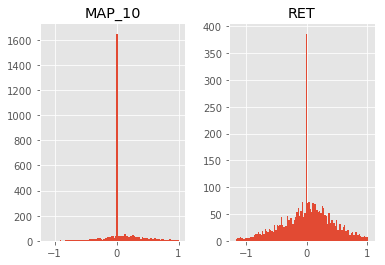

In [546]:
deff=[]
for key in GS_describe.keys():
    #print key
    w = GS_describe[key].T[['RET','MAP_10','realMAP_10']].T
    w.columns=['%s-Mean'%key   ,  '%s-Std'%key    ,  '%s-Skew'%key ,   '%s-SRatio'%key]
    deff.append(w)

pd.concat(deff,axis=1).to_csv('gstemp.csv')

test[['RET','MAP_10']].hist(bins=100)

In [491]:

print describe.T


test[['RET','MAP_10']].hist(bins=100)

test.reset_index()[['PRC']].plot()
test['diff'] =test['PRC']-test['MA_10']
test['buy']=[ 1  if t>0 else 0 for  t in test['diff']]
test['MAP_10'] =test['RET']*test['buy'] +test['TBill1Mo']*(1-test['buy'])
test[['PRC','MA_10','RET','diff','buy','TBill1Mo','MAP_10']]

,PRC,MA_10,RET,diff,buy,TBill1Mo,MAP_10
20040102,31.667948,NaN,NaN,NaN,0,0.000024,NaN
20040105,31.995093,NaN,0.327144,NaN,0,0.000024,0.000024
20040106,32.042737,NaN,0.047644,NaN,0,0.000024,0.000024
20040107,32.106495,NaN,0.063758,NaN,0,0.000024,0.000024
20040108,32.312897,NaN,0.206402,NaN,0,0.000024,0.000024
20040109,32.203412,NaN,-0.109484,NaN,0,0.000024,0.000024
20040112,32.455268,NaN,0.251856,NaN,0,0.000024,0.000024
20040113,32.350763,NaN,-0.104505,NaN,0,0.000024,0.000024
20040114,32.566598,NaN,0.215835,NaN,0,0.000023,0.000023
20040115,32.623546,32.232476,0.056949,0.391071,1,0.000022,0.056949


In [403]:
count =0
for i in list(test['MAP_10']-test['RET']):
    if float(i)>=0:
        count=count+1
        
print count/3245.0  


0.833590138675


In [9]:
#Google['date']
def run_function(arg):
    return GroupUp(arg[0],arg[1])
    
#zip(dd,range(21)
def GroupUp(period_target,df):
    locals()['period%d'%period_target]=df
#sh={}
#for period_duration,period_target in zip(dd,range(21)):
    #locals()['period%d'%period_target] = Google[(Google.date<=period_duration[1]) &  (Google.date>=period_duration[0])]
    #locals()['period%d'%period_target]['period']=period_target
    wd =pd.DataFrame(locals()['period%d'%period_target].set_index('date').mean())
    wd.columns =['Period'+str(period_target)+'MeanGS']
    wdt =pd.concat(GroupChunk(wd,10,'Period'+str(period_target)+'MeanGS').values())
    #wdt.columns =['Period'+str(period_target)+'MeanGS','Group']
    
    wddt =wdt[['Group']].to_dict()['Group']
    for ticker in wddt.keys():
        locals()['period%d'%period_target][ticker+'Group'] = wddt[ticker]
    #sh.update({period_target:locals()['period%d'%period_target]})
    return locals()['period%d'%period_target]





In [23]:
d=pd.DataFrame(np.arange(16).reshape((4,4)),index=['a','b','c','d'],columns=['one','two','three','four'])  
d[['one']].to_dict()

{'one': {'a': 0, 'b': 4, 'c': 8, 'd': 12}}

(3185, 5)
(2114, 5)


RET       0.000380
MAP_10    0.002196
dtype: float64

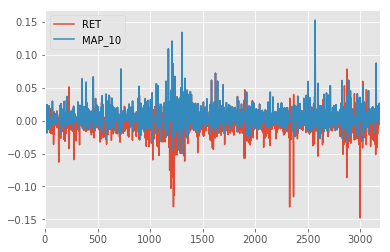

In [131]:
www =ww[['date','PRC','RET','MAP_10','realMAP_10']]
#www[www['realMAP_10']==www['realMAP_10'].max()]

#www[www['date']==20070622]

print www.shape
def deleteoutlier(df):
    return df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() <1.545).all(axis=1)]

wwww =deleteoutlier(www)
#wwww[wwww['realMAP_10']==wwww['realMAP_10'].max()] 
print wwww.shape
www[['RET','MAP_10']].plot()
wwww[['RET','MAP_10']].mean()




In [23]:
#calMAEMA_pool(groupbyticker[1])['realMAP_10'].describe()
share_d.keys()[1]


'AGN'

In [103]:
pool =mp.Pool()
calculatedticker =pool.map(calMAEMA_pool,groupbyticker) 
pool.close()
pool.join()

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


KeyError: 'TBill1Mo'

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipy